# 背景介绍
幸福感是一个古老而深刻的话题，是人类世代追求的方向。与幸福感相关的因素成千上万、因人而异，大如国计民生，小如路边烤红薯，都
会对幸福感产生影响。这些错综复杂的因素中，我们能找到其中的共性，一窥幸福感的要义吗？

另外，在社会科学领域，幸福感的研究占有重要的位置。这个涉及了哲学、心理学、社会学、经济学等多方学科的话题复杂而有趣；同时与
大家生活息息相关，每个人对幸福感都有自己的衡量标准。如果能发现影响幸福感的共性，生活中是不是将多一些乐趣；如果能找到影响幸福感的政策因素，便能优化资源配置来提升国民的幸福感。目前社会科学研究注重变量的可解释性和未来政策的落地，主要采用了线性回归和逻辑回归的方法，在收入、健康、职业、社交关系、休闲方式等经济人口因素；以及政府公共服务、宏观经济环境、税负等宏观因素上有了一系列的推测和发现。

该案例为幸福感预测这一经典课题，希望在现有社会科学研究外有其他维度的算法尝试，结合多学科各自优势，挖掘潜在的影响因素，发现
更多可解释、可理解的相关关系。具体来说，该案例就是一个数据挖掘类型的比赛——幸福感预测的baseline。具体来说，我们需要使用包括个体变量（性别、年龄、地域、
职业、健康、婚姻与政治面貌等等）、家庭变量（父母、配偶、子女、家庭资本等等）、社会态度（公平、信用、公共服务等等）等139维
度的信息来预测其对幸福感的影响。
我们的数据来源于国家官方的《中国综合社会调查（CGSS）》文件中的调查结果中的数据，数据来源可靠可依赖:)

# 数据信息
赛题要求使用以上 139 维的特征，使用 8000 余组数据进行对于个人幸福感的预测（预测值为1，2，3，4，5，其中1代表幸福感最低，5代
表幸福感最高）。
因为考虑到变量个数较多，部分变量间关系复杂，数据分为完整版和精简版两类。可从精简版入手熟悉赛题后，使用完整版挖掘更多信息。在这里我直接使用了完整版的数据。赛题也给出了index文件中包含每个变量对应的问卷题目，以及变量取值的含义；survey文件中为原版问卷，作为补充以方便理解问题背景。

# 评价指标
MSE Loss:

$$Score = \sum_i^n (y_i - y_i^*)^2$$

$y_i$ 是target, $y_i^*$是prediction


In [1]:
# utilities
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import ExtraTreesRegressor as etr
from sklearn.linear_model import BayesianRidge as br
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import ElasticNet as en
from sklearn.kernel_ridge import KernelRidge as kr

import lightgbm as lgb
import xgboost as xgb


# metrics
from sklearn import metrics
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error,mean_absolute_error, f1_score


from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import logging
import warnings
warnings.filterwarnings('ignore') #消除warning


In [2]:
! git clone https://github.com/datawhalechina/team-learning-data-mining.git
! cp /content/team-learning-data-mining/EnsembleLearning/CH6-集成学习之案例分享/集成学习案例分析1/* .

Cloning into 'team-learning-data-mining'...
remote: Enumerating objects: 1234, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 1234 (delta 213), reused 225 (delta 206), pack-reused 967
Receiving objects: 100% (1234/1234), 81.21 MiB | 29.61 MiB/s, done.
Resolving deltas: 100% (535/535), done.


In [3]:
# !mv team-learning-data-mining/ drive/MyDrive/Colab\ Notebooks/Ensemble-Learning

In [4]:

train = pd.read_csv("train.csv", parse_dates=['survey_time'],encoding='latin-1')
test = pd.read_csv("test.csv", parse_dates=['survey_time'],encoding='latin-1') #latin-1向下兼容ASCII
train = train[train["happiness"]!=-8].reset_index(drop=True)
train_data_copy = train.copy() #删去"happiness" 为-8的行
target_col = "happiness" #目标列
target = train_data_copy[target_col]
del train_data_copy[target_col] #去除目标列
data = pd.concat([train_data_copy,test],axis=0,ignore_index=True)
train.happiness.describe() #数据的基本信息


count    7988.000000
mean        3.867927
std         0.818717
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: happiness, dtype: float64

# 做一下数据分析

In [5]:
data.head()

,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,...,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,1,12,32,59,2015-08-04 14:18:00,1,1959,1,1,1,11,NaN,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,...,40000.0,5.0,NaN,NaN,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60.0,50,50,30.0,30,50,50,50
1,2,2,18,52,85,2015-07-21 15:04:00,1,1992,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,...,NaN,NaN,NaN,NaN,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70.0,70,80,85.0,70,90,60,60
2,3,2,29,83,126,2015-07-21 13:24:00,2,1967,1,0,3,4,NaN,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,...,6000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80.0,75,79,80.0,90,90,90,75
3,4,2,10,28,51,2015-07-25 17:33:00,2,1943,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,...,NaN,NaN,NaN,NaN,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90.0,70,80,80.0,90,90,80,80
4,5,1,7,18,36,2015-08-10 09:50:00,2,1994,1,1,1,12,NaN,1.0,2014.0,-1,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,...,NaN,NaN,NaN,NaN,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50.0,50,50,50.0,50,50,50,50


In [6]:
data.count()

id                  10956
survey_type         10956
province            10956
city                10956
county              10956
                    ...  
public_service_5    10956
public_service_6    10956
public_service_7    10956
public_service_8    10956
public_service_9    10956
Length: 139, dtype: int64

In [6]:
train.happiness.unique()

array([4, 5, 2, 3, 1])

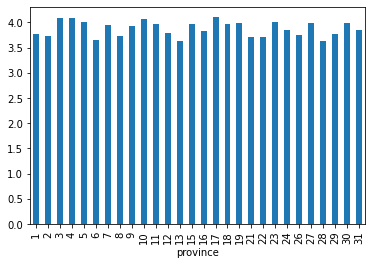

In [11]:
train.happiness.groupby(by=train.province).mean().plot.bar()

Text(0, 0.5, 'mean income')

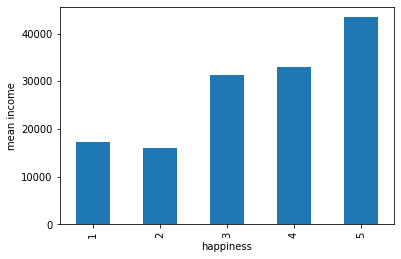

In [31]:
ax = train.income.groupby(by=train.happiness).mean().plot.bar(x='income',y='happiness')
ax.set_ylabel('mean income')

Text(0, 0.5, 'mean marital')

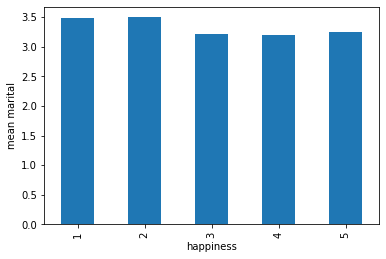

In [26]:
ax1 = train.marital.groupby(by=train.happiness).mean().plot.bar()
ax1.set_ylabel('mean marital')

Text(0, 0.5, 'mean happiness')

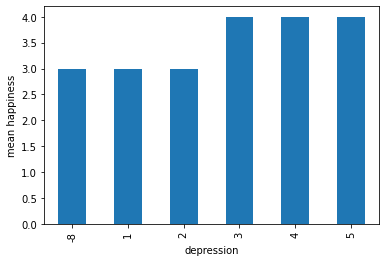

In [45]:
ax2 = train.happiness.groupby(by=train.depression).median() .plot.bar()
ax2.set_ylabel('mean happiness')


In [36]:
# train.political.unique()

array([ 1,  2,  4, -8,  3])

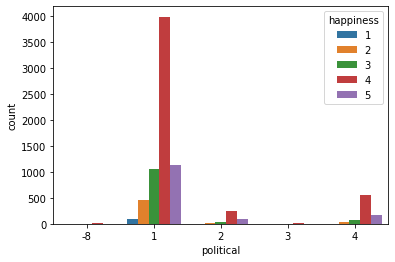

In [41]:
ax1 = sns.countplot(x= train.political,hue=train.happiness)


Text(0, 0.5, 'happiness count')

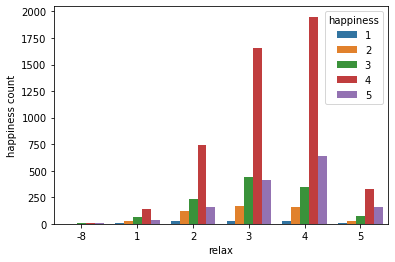

In [53]:
ax1 = sns.countplot(x= train.relax,hue=train.happiness)
# ax1 = train.happiness.groupby(by=train.relax).mean().plot.bar()
ax1.set_ylabel('happiness count')

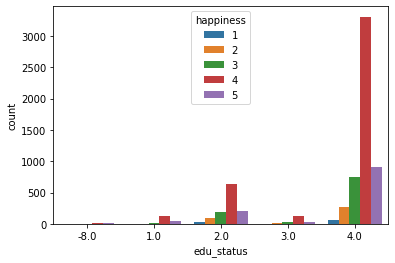

In [65]:
# ax1 = sns.countplot(x= train.relax,hue=train.happiness)
ax1 = sns.countplot(x= train.edu_status,hue=train.happiness)
# train.happiness.groupby(by=train.edu_status).sum().plot.bar()

简单分析了几个个feature，一下几点
+ 发现收入越高越开心
+ 越开心时婚姻关系好像有点不好，反倒大多数人越开心压力越大，有点意思，可能是因为带来开心的来源往往会伴随更大的压力。
+ 越是和政治相关越是不开心，出来混不容易啊
+ 适度放松会适度开心，过度放松(5)会不太开心，可能过度放纵没意思了吧
+ 大多数调查的人的教育程度也是挺高的而且还挺开心。但是教育程度很低就不太开心了

# 2. Data Preprocessing

In [7]:
#make feature +5
#csv中有复数值：-1、-2、-3、-8，将他们视为有问题的特征，但是不删去
def getres1(row):
  return len([x for x in row.values if type(x)==int and x<0])
def getres2(row):
  return len([x for x in row.values if type(x)==int and x==-8])
def getres3(row):
  return len([x for x in row.values if type(x)==int and x==-1])
def getres4(row):
  return len([x for x in row.values if type(x)==int and x==-2])
def getres5(row):
  return len([x for x in row.values if type(x)==int and x==-3])


In [8]:
#检查数据
data['neg1'] = data[data.columns].apply(lambda row:getres1(row),axis=1)
data.loc[data['neg1']>20,'neg1'] = 20 #平滑处理,最多出现20次
data['neg2'] = data[data.columns].apply(lambda row:getres2(row),axis=1)
data['neg3'] = data[data.columns].apply(lambda row:getres3(row),axis=1)
data['neg4'] = data[data.columns].apply(lambda row:getres4(row),axis=1)
data['neg5'] = data[data.columns].apply(lambda row:getres5(row),axis=1)

In [9]:
work_cols = [i for i in data.columns if 'work' in i.split('_')[0]] # columns start with work_
s_cols = [i for i in data.columns if 's' == i.split('_')[0]] # columns start with s_
edu_cols = [i for i in data.columns if 'edu' == i.split('_')[0]] # columns start with s_

for col in work_cols:
  data[col]= data[col].fillna(0)
for col in s_cols:
  data[col]= data[col].fillna(0)

for col in ['edu_yr', 'edu_status','minor_child','marital_now','marital_1st','social_neighbor','social_friend']:
  data[col]= data[col].fillna(0)

data['hukou_loc']=data['hukou_loc'].fillna(1) #最少为1，表示户口
data['family_income']=data['family_income'].fillna(66365) #删除问题值后的平均值



In [10]:
# #填充缺失值 共25列 去掉4列 填充21列
# #以下的列都是缺省的，视情况填补
# data['work_status'] = data['work_status'].fillna(0)
# data['work_yr'] = data['work_yr'].fillna(0)
# data['work_manage'] = data['work_manage'].fillna(0)
# data['work_type'] = data['work_type'].fillna(0)
# data['edu_yr'] = data['edu_yr'].fillna(0)
# data['edu_status'] = data['edu_status'].fillna(0)

# data['s_work_type'] = data['s_work_type'].fillna(0)
# data['s_work_status'] = data['s_work_status'].fillna(0)
# data['s_political'] = data['s_political'].fillna(0)
# data['s_hukou'] = data['s_hukou'].fillna(0)
# data['s_income'] = data['s_income'].fillna(0)
# data['s_birth'] = data['s_birth'].fillna(0)
# data['s_edu'] = data['s_edu'].fillna(0)
# data['s_work_exper'] = data['s_work_exper'].fillna(0)

# data['minor_child'] = data['minor_child'].fillna(0)
# data['marital_now'] = data['marital_now'].fillna(0)
# data['marital_1st'] = data['marital_1st'].fillna(0)
# data['social_neighbor']=data['social_neighbor'].fillna(0)
# data['social_friend']=data['social_friend'].fillna(0)

# data['hukou_loc']=data['hukou_loc'].fillna(1) #最少为1，表示户口
# data['family_income']=data['family_income'].fillna(66365) #删除问题值后的平均值

## 2.2 对特殊数据进行特殊处理
- 通过生日和调查时间计算年龄
- 把年龄分区

In [11]:
#144+1 =145
#继续进行特殊的列进行数据处理
#读happiness_index.xlsx
data['survey_time'] = pd.to_datetime(data['survey_time'], format='%Y-%m-%d',errors='coerce')#防止时间格式不同的报错errors='coerce‘
data['survey_time'] = data['survey_time'].dt.year #仅仅是year，方便计算年龄
data['age'] = data['survey_time']-data['birth']
# print(data['age'],data['survey_time'],data['birth'])
#年龄分层 145+1=146
bins = [0,17,26,34,50,63,100]
data['age_bin'] = pd.cut(data['age'], bins, labels=[0,1,2,3,4,5])

In [12]:
data['religion'].unique(), data['religion_freq'].unique()

(array([ 1,  0, -8]), array([ 1,  3,  8,  4,  2,  9,  6, -8,  7,  5]))

# 对一些异常的特征进行处理

In [13]:
#对‘宗教’处理
data.loc[data['religion']<0,'religion'] = 1 #1为不信仰宗教
data.loc[data['religion_freq']<0,'religion_freq'] = 1 #1为从来没有参加过
#对‘教育程度’处理
data.loc[data['edu']<0,'edu'] = 4 #初中
data.loc[data['edu_status']<0,'edu_status'] = 0
data.loc[data['edu_yr']<0,'edu_yr'] = 0
#对‘个人收入’处理
data.loc[data['income']<0,'income'] = 0 #认为无收入
#对‘政治面貌’处理
data.loc[data['political']<0,'political'] = 1 #认为是群众
#对体重处理
data.loc[(data['weight_jin']<=80)&(data['height_cm']>=160),'weight_jin']= data['weight_jin']*2
data.loc[data['weight_jin']<=60,'weight_jin']= data['weight_jin']*2 #个人的想法，哈哈哈，没有60斤的成年人吧
#对身高处理
data.loc[data['height_cm']<150,'height_cm'] = 150 #成年人的实际情况
#对‘健康’处理
data.loc[data['health']<0,'health'] = 4 #认为是比较健康
data.loc[data['health_problem']<0,'health_problem'] = 4
#对‘沮丧’处理
data.loc[data['depression']<0,'depression'] = 4 #一般人都是很少吧
#对‘媒体’处理
data.loc[data['media_1']<0,'media_1'] = 1 #都是从不
data.loc[data['media_2']<0,'media_2'] = 1
data.loc[data['media_3']<0,'media_3'] = 1
data.loc[data['media_4']<0,'media_4'] = 1
data.loc[data['media_5']<0,'media_5'] = 1
data.loc[data['media_6']<0,'media_6'] = 1
#对‘空闲活动’处理
data.loc[data['leisure_1']<0,'leisure_1'] = 1 #都是根据自己的想法
data.loc[data['leisure_2']<0,'leisure_2'] = 5
data.loc[data['leisure_3']<0,'leisure_3'] = 3

In [14]:
# 用众数对outlier进行填补
data.loc[data['leisure_4']<0,'leisure_4'] = data['leisure_4'].mode() #取众数
data.loc[data['leisure_5']<0,'leisure_5'] = data['leisure_5'].mode()
data.loc[data['leisure_6']<0,'leisure_6'] = data['leisure_6'].mode()
data.loc[data['leisure_7']<0,'leisure_7'] = data['leisure_7'].mode()
data.loc[data['leisure_8']<0,'leisure_8'] = data['leisure_8'].mode()
data.loc[data['leisure_9']<0,'leisure_9'] = data['leisure_9'].mode()
data.loc[data['leisure_10']<0,'leisure_10'] = data['leisure_10'].mode()
data.loc[data['leisure_11']<0,'leisure_11'] = data['leisure_11'].mode()
data.loc[data['leisure_12']<0,'leisure_12'] = data['leisure_12'].mode()

data.loc[data['socialize']<0,'socialize'] = 2 #很少
data.loc[data['relax']<0,'relax'] = 4 #经常
data.loc[data['learn']<0,'learn'] = 1 #从不，哈哈哈哈
#对‘社交’处理
data.loc[data['social_neighbor']<0,'social_neighbor'] = 0
data.loc[data['social_friend']<0,'social_friend'] = 0
data.loc[data['socia_outing']<0,'socia_outing'] = 1
data.loc[data['neighbor_familiarity']<0,'social_neighbor']= 4
#对‘社会公平性’处理
data.loc[data['equity']<0,'equity'] = 4

#对‘社会等级’处理
data.loc[data['class_10_before']<0,'class_10_before'] = 3
data.loc[data['class']<0,'class'] = 5
data.loc[data['class_10_after']<0,'class_10_after'] = 5
data.loc[data['class_14']<0,'class_14'] = 2

In [15]:

#对‘工作情况’处理
data.loc[data['work_status']<0,'work_status'] = 0
data.loc[data['work_yr']<0,'work_yr'] = 0
data.loc[data['work_manage']<0,'work_manage'] = 0
data.loc[data['work_type']<0,'work_type'] = 0
#对‘社会保障’处理
data.loc[data['insur_1']<0,'insur_1'] = 1
data.loc[data['insur_2']<0,'insur_2'] = 1
data.loc[data['insur_3']<0,'insur_3'] = 1
data.loc[data['insur_4']<0,'insur_4'] = 1
data.loc[data['insur_1']==0,'insur_1'] = 0
data.loc[data['insur_2']==0,'insur_2'] = 0
data.loc[data['insur_3']==0,'insur_3'] = 0
data.loc[data['insur_4']==0,'insur_4'] = 0

对连续值进行missing value的补全，这里使用mean value

In [16]:
#对家庭情况处理
family_income_mean = data['family_income'].mean()
data.loc[data['family_income']<0,'family_income'] = family_income_mean
# outlier 处理
data.loc[data['family_m']<0,'family_m'] = 2
data.loc[data['family_status']<0,'family_status'] = 3
data.loc[data['house']<0,'house'] = 1
data.loc[data['car']<0,'car'] = 0
data.loc[data['car']==2,'car'] = 0
data.loc[data['son']<0,'son'] = 1
data.loc[data['daughter']<0,'daughter'] = 0
data.loc[data['minor_child']<0,'minor_child'] = 0
#对‘婚姻’处理
data.loc[data['marital_1st']<0,'marital_1st'] = 0
data.loc[data['marital_now']<0,'marital_now'] = 0
#对‘配偶’处理
data.loc[data['s_birth']<0,'s_birth'] = 0
data.loc[data['s_edu']<0,'s_edu'] = 0
data.loc[data['s_political']<0,'s_political'] = 0
data.loc[data['s_hukou']<0,'s_hukou'] = 0
data.loc[data['s_income']<0,'s_income'] = 0
data.loc[data['s_work_type']<0,'s_work_type'] = 0
data.loc[data['s_work_status']<0,'s_work_status'] = 0
data.loc[data['s_work_exper']<0,'s_work_exper'] = 0
#对‘父母情况’处理
data.loc[data['f_birth']<0,'f_birth'] = 1945
data.loc[data['f_edu']<0,'f_edu'] = 1
data.loc[data['f_political']<0,'f_political'] = 1
data.loc[data['f_work_14']<0,'f_work_14'] = 2
data.loc[data['m_birth']<0,'m_birth'] = 1940
data.loc[data['m_edu']<0,'m_edu'] = 1
data.loc[data['m_political']<0,'m_political'] = 1
data.loc[data['m_work_14']<0,'m_work_14'] = 2
#和同龄人相比社会经济地位
data.loc[data['status_peer']<0,'status_peer'] = 2
#和3年前比社会经济地位
data.loc[data['status_3_before']<0,'status_3_before'] = 2
#对‘观点’处理
data.loc[data['view']<0,'view'] = 4
#对期望年收入处理
data.loc[data['inc_ability']<=0,'inc_ability']= 2
inc_exp_mean = data['inc_exp'].mean()
data.loc[data['inc_exp']<=0,'inc_exp']= inc_exp_mean #取均值

#部分特征处理，取众数
for i in range(1,9+1):
  data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)] =data['public_service_'+str(i)].dropna().mode()#.values
  data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)] = data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)].dropna()
for i in range(1,13+1):
  data.loc[data['trust_'+str(i)]<0,'trust_'+str(i)] = data['trust_'+str(i)].dropna().mode()#.values
  data.loc[data['trust_'+str(i)]<0,'trust_'+str(i)] = data.loc[data['trust_'+str(i)]<0,'trust_'+str(i)].dropna()

# 特征的组合和扩增
这里考虑添加以下数据来考虑和幸福度的关系:
 第一次结婚年龄、最近结婚年龄、是否再婚、配偶年龄、配偶年龄差、各种收入比（与配偶之间的收入比、十年后预期收入与现在收入之比等等）、收入与住房面积
比（其中也包括10年后期望收入等等各种情况）、社会阶级（10年后的社会阶级、14年后的社会阶级等等）、悠闲指数、满意指数、信任指
数等等。除此之外，我还考虑了对于同一省、市、县进行了归一化。例如同一省市内的收入的平均值等以及一个个体相对于同省、市、县其
他人的各个指标的情况。同时也考虑了对于同龄人之间的相互比较，即在同龄人中的收入情况、健康情况等等。具体的实现代码如下：

In [17]:
#第一次结婚年龄 147
data['marital_1stbir'] = data['marital_1st'] - data['birth']
#最近结婚年龄 148
data['marital_nowtbir'] = data['marital_now'] - data['birth']
#是否再婚 149
data['mar'] = data['marital_nowtbir'] - data['marital_1stbir']

#配偶年龄 150
data['marital_sbir'] = data['marital_now']-data['s_birth']
#配偶年龄差 151
data['age_'] = data['marital_nowtbir'] - data['marital_sbir']
#收入比 151+7 =158
data['income/s_income'] = data['income']/(data['s_income']+1)
data['income+s_income'] = data['income']+(data['s_income']+1)
data['income/family_income'] = data['income']/(data['family_income']+1)
data['all_income/family_income'] = (data['income']+data['s_income'])/(data['family_income']+1)
data['income/inc_exp'] = data['income']/(data['inc_exp']+1)
data['family_income/m'] = data['family_income']/(data['family_m']+0.01)
data['income/m'] = data['income']/(data['family_m']+0.01)

#收入/面积比 158+4=162
data['income/floor_area'] = data['income']/(data['floor_area']+0.01)
data['all_income/floor_area'] = (data['income']+data['s_income'])/(data['floor_area']+0.01)
data['family_income/floor_area'] = data['family_income']/(data['floor_area']+0.01)
data['floor_area/m'] = data['floor_area']/(data['family_m']+0.01)

#class 162+3=165
data['class_10_diff'] = (data['class_10_after'] - data['class'])
data['class_diff'] = data['class'] - data['class_10_before']
data['class_14_diff'] = data['class'] - data['class_14']
#悠闲指数 166
leisure_fea_lis = ['leisure_'+str(i) for i in range(1,13)]
data['leisure_sum'] = data[leisure_fea_lis].sum(axis=1) #skew
#满意指数 167
public_service_fea_lis = ['public_service_'+str(i) for i in range(1,10)]
data['public_service_sum'] = data[public_service_fea_lis].sum(axis=1) #skew

#信任指数 168
trust_fea_lis = ['trust_'+str(i) for i in range(1,14)]
data['trust_sum'] = data[trust_fea_lis].sum(axis=1) #skew
#province mean 168+13=181
data['province_income_mean'] = data.groupby(['province'])['income'].transform('mean').values
data['province_family_income_mean'] = data.groupby(['province'])['family_income'].transform('mean').values
data['province_equity_mean'] = data.groupby(['province'])['equity'].transform('mean').values
data['province_depression_mean'] = data.groupby(['province'])['depression'].transform('mean').values
data['province_floor_area_mean'] = data.groupby(['province'])['floor_area'].transform('mean').values
data['province_health_mean'] = data.groupby(['province'])['health'].transform('mean').values
data['province_class_10_diff_mean'] = data.groupby(['province'])['class_10_diff'].transform('mean').values
data['province_class_mean'] = data.groupby(['province'])['class'].transform('mean').values
data['province_health_problem_mean'] = data.groupby(['province'])['health_problem'].transform('mean').values
data['province_family_status_mean'] = data.groupby(['province'])['family_status'].transform('mean').values
data['province_leisure_sum_mean'] = data.groupby(['province'])['leisure_sum'].transform('mean').values
data['province_public_service_sum_mean'] = data.groupby(['province'])['public_service_sum'].transform('mean').values
data['province_trust_sum_mean'] = data.groupby(['province'])['trust_sum'].transform('mean').values

#city mean 181+13=194
data['city_income_mean'] = data.groupby(['city'])['income'].transform('mean').values
data['city_family_income_mean'] = data.groupby(['city'])['family_income'].transform('mean').values
data['city_equity_mean'] = data.groupby(['city'])['equity'].transform('mean').values
data['city_depression_mean'] = data.groupby(['city'])['depression'].transform('mean').values
data['city_floor_area_mean'] = data.groupby(['city'])['floor_area'].transform('mean').values
data['city_health_mean'] = data.groupby(['city'])['health'].transform('mean').values
data['city_class_10_diff_mean'] = data.groupby(['city'])['class_10_diff'].transform('mean').values
data['city_class_mean'] = data.groupby(['city'])['class'].transform('mean').values
data['city_health_problem_mean'] = data.groupby(['city'])['health_problem'].transform('mean').values
data['city_family_status_mean'] = data.groupby(['city'])['family_status'].transform('mean').values
data['city_leisure_sum_mean'] = data.groupby(['city'])['leisure_sum'].transform('mean').values
data['city_public_service_sum_mean'] = data.groupby(['city'])['public_service_sum'].transform('mean').values
data['city_trust_sum_mean'] = data.groupby(['city'])['trust_sum'].transform('mean').values
#county mean 194 + 13 = 207
data['county_income_mean'] = data.groupby(['county'])['income'].transform('mean').values
data['county_family_income_mean'] = data.groupby(['county'])['family_income'].transform('mean').values
data['county_equity_mean'] = data.groupby(['county'])['equity'].transform('mean').values
data['county_depression_mean'] = data.groupby(['county'])['depression'].transform('mean').values
data['county_floor_area_mean'] = data.groupby(['county'])['floor_area'].transform('mean').values
data['county_health_mean'] = data.groupby(['county'])['health'].transform('mean').values
data['county_class_10_diff_mean'] = data.groupby(['county'])['class_10_diff'].transform('mean').values
data['county_class_mean'] = data.groupby(['county'])['class'].transform('mean').values
data['county_health_problem_mean'] = data.groupby(['county'])['health_problem'].transform('mean').values
data['county_family_status_mean'] = data.groupby(['county'])['family_status'].transform('mean').values
data['county_leisure_sum_mean'] = data.groupby(['county'])['leisure_sum'].transform('mean').values
data['county_public_service_sum_mean'] = data.groupby(['county'])['public_service_sum'].transform('mean').values
data['county_trust_sum_mean'] = data.groupby(['county'])['trust_sum'].transform('mean').values

#ratio 相比同省 207 + 13 =220
data['income/province'] = data['income']/(data['province_income_mean'])
data['family_income/province'] = data['family_income']/(data['province_family_income_mean'])
data['equity/province'] = data['equity']/(data['province_equity_mean'])
data['depression/province'] = data['depression']/(data['province_depression_mean'])
data['floor_area/province'] = data['floor_area']/(data['province_floor_area_mean'])
data['health/province'] = data['health']/(data['province_health_mean'])
data['class_10_diff/province'] = data['class_10_diff']/(data['province_class_10_diff_mean'])
data['class/province'] = data['class']/(data['province_class_mean'])
data['health_problem/province'] = data['health_problem']/(data['province_health_problem_mean'])
data['family_status/province'] = data['family_status']/(data['province_family_status_mean'])
data['leisure_sum/province'] = data['leisure_sum']/(data['province_leisure_sum_mean'])
data['public_service_sum/province'] = data['public_service_sum']/(data['province_public_service_sum_mean'])
data['trust_sum/province'] = data['trust_sum']/(data['province_trust_sum_mean']+1)
#ratio 相比同市 220 + 13 =233
data['income/city'] = data['income']/(data['city_income_mean'])
data['family_income/city'] = data['family_income']/(data['city_family_income_mean'])
data['equity/city'] = data['equity']/(data['city_equity_mean'])
data['depression/city'] = data['depression']/(data['city_depression_mean'])
data['floor_area/city'] = data['floor_area']/(data['city_floor_area_mean'])
data['health/city'] = data['health']/(data['city_health_mean'])
data['class_10_diff/city'] = data['class_10_diff']/(data['city_class_10_diff_mean'])
data['class/city'] = data['class']/(data['city_class_mean'])
data['health_problem/city'] = data['health_problem']/(data['city_health_problem_mean'])
data['family_status/city'] = data['family_status']/(data['city_family_status_mean'])
data['leisure_sum/city'] = data['leisure_sum']/(data['city_leisure_sum_mean'])
data['public_service_sum/city'] = data['public_service_sum']/(data['city_public_service_sum_mean'])
data['trust_sum/city'] = data['trust_sum']/(data['city_trust_sum_mean'])
#ratio 相比同个地区 233 + 13 =246
data['income/county'] = data['income']/(data['county_income_mean'])
data['family_income/county'] = data['family_income']/(data['county_family_income_mean'])
data['equity/county'] = data['equity']/(data['county_equity_mean'])
data['depression/county'] = data['depression']/(data['county_depression_mean'])
data['floor_area/county'] = data['floor_area']/(data['county_floor_area_mean'])
data['health/county'] = data['health']/(data['county_health_mean'])
data['class_10_diff/county'] = data['class_10_diff']/(data['county_class_10_diff_mean'])
data['class/county'] = data['class']/(data['county_class_mean'])
data['health_problem/county'] = data['health_problem']/(data['county_health_problem_mean'])
data['family_status/county'] = data['family_status']/(data['county_family_status_mean'])
data['leisure_sum/county'] = data['leisure_sum']/(data['county_leisure_sum_mean'])
data['public_service_sum/county'] = data['public_service_sum']/(data['county_public_service_sum_mean'])
data['trust_sum/county'] = data['trust_sum']/(data['county_trust_sum_mean'])
#age mean 246+ 13 =259
data['age_income_mean'] = data.groupby(['age'])['income'].transform('mean').values
data['age_family_income_mean'] = data.groupby(['age'])['family_income'].transform('mean').values
data['age_equity_mean'] = data.groupby(['age'])['equity'].transform('mean').values
data['age_depression_mean'] = data.groupby(['age'])['depression'].transform('mean').values
data['age_floor_area_mean'] = data.groupby(['age'])['floor_area'].transform('mean').values
data['age_health_mean'] = data.groupby(['age'])['health'].transform('mean').values
data['age_class_10_diff_mean'] = data.groupby(['age'])['class_10_diff'].transform('mean').values
data['age_class_mean'] = data.groupby(['age'])['class'].transform('mean').values
data['age_health_problem_mean'] = data.groupby(['age'])['health_problem'].transform('mean').values
data['age_family_status_mean'] = data.groupby(['age'])['family_status'].transform('mean').values
data['age_leisure_sum_mean'] = data.groupby(['age'])['leisure_sum'].transform('mean').values
data['age_public_service_sum_mean'] = data.groupby(['age'])['public_service_sum'].transform('mean').values
data['age_trust_sum_mean'] = data.groupby(['age'])['trust_sum'].transform('mean').values
# 和同龄人相比259 + 13 =272
data['income/age'] = data['income']/(data['age_income_mean'])
data['family_income/age'] = data['family_income']/(data['age_family_income_mean'])
data['equity/age'] = data['equity']/(data['age_equity_mean'])
data['depression/age'] = data['depression']/(data['age_depression_mean'])
data['floor_area/age'] = data['floor_area']/(data['age_floor_area_mean'])
data['health/age'] = data['health']/(data['age_health_mean'])
data['class_10_diff/age'] = data['class_10_diff']/(data['age_class_10_diff_mean'])
data['class/age'] = data['class']/(data['age_class_mean'])
data['health_problem/age'] = data['health_problem']/(data['age_health_problem_mean'])
data['family_status/age'] = data['family_status']/(data['age_family_status_mean'])
data['leisure_sum/age'] = data['leisure_sum']/(data['age_leisure_sum_mean'])
data['public_service_sum/age'] = data['public_service_sum']/(data['age_public_service_sum_mean'])
data['trust_sum/age'] = data['trust_sum']/(data['age_trust_sum_mean'])

In [18]:
print('shape',data.shape)
data.head()

shape (10956, 272)


,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,...,trust_sum/city,income/county,family_income/county,equity/county,depression/county,floor_area/county,health/county,class_10_diff/county,class/county,health_problem/county,family_status/county,leisure_sum/county,public_service_sum/county,trust_sum/county,age_income_mean,age_family_income_mean,age_equity_mean,age_depression_mean,age_floor_area_mean,age_health_mean,age_class_10_diff_mean,age_class_mean,age_health_problem_mean,age_family_status_mean,age_leisure_sum_mean,age_public_service_sum_mean,age_trust_sum_mean,income/age,family_income/age,equity/age,depression/age,floor_area/age,health/age,class_10_diff/age,class/age,health_problem/age,family_status/age,leisure_sum/age,public_service_sum/age,trust_sum/age
0,1,1,12,32,59,2015,1,1959,1,1,1,11,NaN,4.0,0.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,...,0.886849,0.690141,0.989600,1.166667,1.225000,1.167903,0.859649,0.000000,0.607438,0.515789,0.803279,0.899333,0.751122,0.988932,24371.808219,68176.863103,3.061644,3.890411,109.662329,3.534247,0.479452,4.390411,3.835616,2.726027,45.541096,608.657534,36.054795,0.820620,0.880064,0.979866,1.285211,0.410351,0.848837,0.000000,0.683307,0.521429,0.733668,0.724620,0.690043,0.859802
1,2,2,18,52,85,2015,1,1992,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,...,1.030360,1.719889,1.150775,0.895385,0.757812,0.711476,1.272966,2.179775,1.455000,1.013055,1.453184,0.801993,1.072921,1.006273,20771.900826,71278.333790,3.157025,4.090909,115.446281,4.239669,1.975207,4.462810,4.487603,2.942149,38.545455,579.082645,39.107438,0.962839,0.561180,0.950262,0.733333,0.952824,1.179337,1.012552,1.344444,0.891344,1.359551,1.011792,1.165637,1.099535
2,3,2,29,83,126,2015,2,1967,1,0,3,4,NaN,4.0,0.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,...,0.902552,0.306649,0.246326,1.214058,1.263298,0.994331,1.085714,1.266667,1.109813,1.041096,1.083650,0.932388,1.144302,0.902552,23468.987342,51169.410130,3.025316,3.721519,123.415190,3.476793,0.839662,4.181435,3.789030,2.518987,46.561181,607.130802,37.772152,0.085219,0.156343,1.322176,1.343537,0.972328,1.150485,1.190955,1.195762,1.055679,1.190955,0.966470,1.233672,0.926609
3,4,2,10,28,51,2015,2,1943,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,...,1.147826,0.142423,0.117516,1.229814,0.992481,0.789006,0.982630,2.869565,1.119910,0.977778,1.112360,1.006383,1.203224,1.147826,15072.375000,123040.453017,3.348214,3.598214,121.433036,3.133929,0.401786,4.169643,3.366071,2.580357,47.812500,607.258929,36.857143,0.425945,0.097529,1.194667,1.111663,0.642329,1.276353,4.977778,1.199143,1.188329,1.162630,0.899346,1.251525,1.193798
4,5,1,7,18,36,2015,2,1994,1,1,1,12,NaN,1.0,2014.0,0,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,...,1.348372,0.000000,0.777762,0.557143,0.754839,1.216252,1.250000,0.000000,0.274648,1.196319,0.991525,0.891938,0.877061,1.120836,14158.165138,69150.138536,3.082569,4.000000,119.192661,4.247706,1.779817,4.220183,4.477064,2.743119,38.266055,595.243119,41.743119,0.000000,0.959733,0.648810,0.750000,0.587284,1.177106,0.000000,0.236957,1.116803,1.093645,1.045313,0.755994,1.054066


删除缺失值太多的columns以及之前用过的columns(避免特征线性相关)

In [19]:
#272-9=263
#删除数值特别少的和之前用过的特征
del_list=['id','survey_time','edu_other','invest_other','property_other','join_party','province','city','county']
use_feature = [clo for clo in data.columns if clo not in del_list]
data.fillna(0,inplace=True) #还是补0
train_shape = train.shape[0] #一共的数据量，训练集
features = data[use_feature].columns #删除后所有的特征
X_train_263 = data[:train_shape][use_feature].values
y_train = target
X_test_263 = data[train_shape:][use_feature].values
X_train_263.shape #最终一种263个特征

(7988, 263)

选取272个特征中最重要的49个特征进行分析

In [20]:
imp_fea_49 = ['equity','depression','health','class','family_status','health_problem','class_10_after',
'equity/province','equity/city','equity/county',
'depression/province','depression/city','depression/county',
'health/province','health/city','health/county',
'class/province','class/city','class/county',
'family_status/province','family_status/city','family_status/county',
'family_income/province','family_income/city','family_income/county',
'floor_area/province','floor_area/city','floor_area/county',
'leisure_sum/province','leisure_sum/city','leisure_sum/county',
'public_service_sum/province','public_service_sum/city','public_service_sum/county',
'trust_sum/province','trust_sum/city','trust_sum/county',
'income/m','public_service_sum','class_diff','status_3_before','age_income_mean','age_floor_area_mean',
'weight_jin','height_cm',
'health/age','depression/age','equity/age','leisure_sum/age'
]
train_shape = train.shape[0]
# convert pandas dataframe to numpy array
X_train_49 = data[:train_shape][imp_fea_49].values
X_test_49 = data[train_shape:][imp_fea_49].values
X_train_49.shape #最重要的49个特征

(7988, 49)

In [21]:
data.shape

(10956, 272)

OneHot-Encoding 转化原来的272个特征里面的categorical features

In [22]:
cat_fea = ['survey_type','gender','nationality','edu_status','political','hukou','hukou_loc','work_exper','work_status','work_type',
'work_manage','marital','s_political','s_hukou','s_work_exper','s_work_status','s_work_type','f_political','f_work_14',
'm_political','m_work_14']
noc_fea = [clo for clo in use_feature if clo not in cat_fea]
onehot_data = data[cat_fea].values
enc = preprocessing.OneHotEncoder(categories = 'auto')
oh_data=enc.fit_transform(onehot_data).toarray()
oh_data.shape #变为onehot编码格式
X_train_oh = oh_data[:train_shape,:]
X_test_oh = oh_data[train_shape:,:]
X_train_oh.shape #其中的训练集
X_train_383 = np.column_stack([data[:train_shape][noc_fea].values,X_train_oh])#先是noc，再是cat_fea
X_test_383 = np.column_stack([data[train_shape:][noc_fea].values,X_test_oh])
X_train_383.shape

(7988, 383)

# 2. Modeling
这里选用以下的模型
- LGBM
- XGBoost
- Random Forest
- Stacking with stage 2 model of ElasticNet

In [23]:
#lightGBM决策树
lgb_263_param = {
'num_leaves': 7,
'min_data_in_leaf': 20, #叶子可能具有的最小记录数
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.003,
"boosting": "gbdt", #用gbdt算法
"feature_fraction": 0.18, #例如 0.18时，意味着在每次迭代中随机选择18％的参数来建树
"bagging_freq": 1,
"bagging_fraction": 0.55, #每次迭代时用的数据比例
"bagging_seed": 14,
"metric": 'mse',
"lambda_l1": 0.1005,
"lambda_l2": 0.1996,
"verbosity": -1}
RANDOM_STATE = 4
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_lgb_263 = np.zeros(len(X_train_263)) # 储存 LGBM的CV预测输出
predictions_lgb_263 = np.zeros(len(X_test_263)) # 储存LGB的test set的输出用于后面的 Ensemble learning Stacking 的环节

for i, (trn_idx, val_idx) in enumerate(folds.split(X_train_263,y_train)):
  trn_data = lgb.Dataset(X_train_263[trn_idx],y_train[trn_idx])
  val_data = lgb.Dataset(X_train_263[val_idx], y_train[val_idx])#train:val=4:1
  num_round = 10000
  lgb_263 = lgb.train(lgb_263_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds =
  800)
  oof_lgb_263[val_idx] = lgb_263.predict(X_train_263[val_idx], num_iteration=lgb_263.best_iteration)
  
  # make prediction on test set with mean values
  predictions_lgb_263 += lgb_263.predict(X_test_263, num_iteration=lgb_263.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_263, target)))

Training until validation scores don't improve for 800 rounds.
[500]	training's l2: 0.499982	valid_1's l2: 0.532811
[1000]	training's l2: 0.451888	valid_1's l2: 0.500866
[1500]	training's l2: 0.42607	valid_1's l2: 0.488106
[2000]	training's l2: 0.408148	valid_1's l2: 0.482351
[2500]	training's l2: 0.393936	valid_1's l2: 0.479115
[3000]	training's l2: 0.381742	valid_1's l2: 0.477309
[3500]	training's l2: 0.370984	valid_1's l2: 0.475868
[4000]	training's l2: 0.361257	valid_1's l2: 0.474433
[4500]	training's l2: 0.352307	valid_1's l2: 0.473648
[5000]	training's l2: 0.343973	valid_1's l2: 0.473344
[5500]	training's l2: 0.335941	valid_1's l2: 0.472972
[6000]	training's l2: 0.328318	valid_1's l2: 0.472581
[6500]	training's l2: 0.321006	valid_1's l2: 0.472468
[7000]	training's l2: 0.313976	valid_1's l2: 0.472438
[7500]	training's l2: 0.307314	valid_1's l2: 0.472313
[8000]	training's l2: 0.300795	valid_1's l2: 0.472056
[8500]	training's l2: 0.294524	valid_1's l2: 0.472057
[9000]	training's l2:

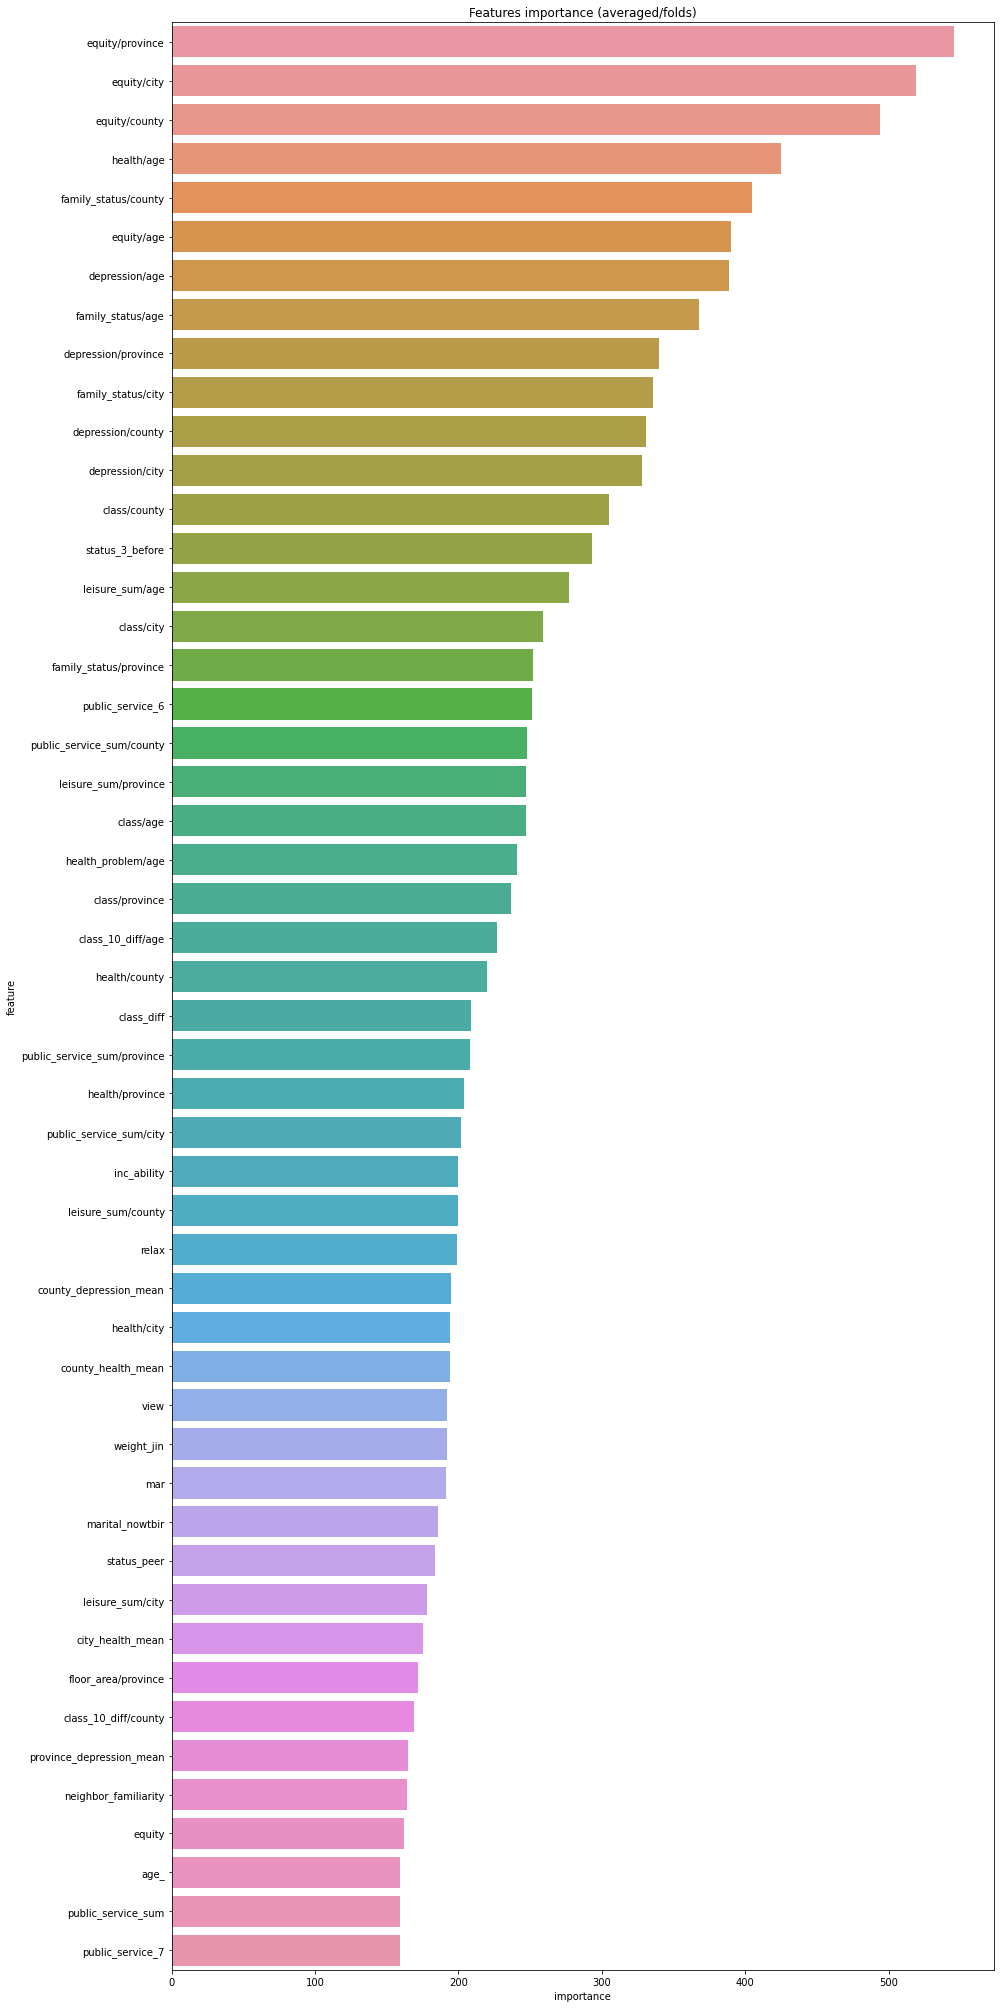

In [24]:
#---------------特征重要性
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
df = pd.DataFrame(data[use_feature].columns.tolist(), columns=['feature'])

# 利用LGBM的tree的feature importance 对特征进行分析
df['importance']=list(lgb_263.feature_importance())
df = df.sort_values(by='importance',ascending=False)
plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=df.head(50))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

使用XGBoost 模型进行训练

In [25]:
##### xgb_263
#xgboost
xgb_263_params = {'eta': 0.02, #lr
          'max_depth': 6,
          'min_child_weight':3,#最小叶子节点样本权重和
          'gamma':0, #指定节点分裂所需的最小损失函数下降值。
          'subsample': 0.7, #控制对于每棵树，随机采样的比例
          'colsample_bytree': 0.3, #用来控制每棵随机采样的列数的占比 (每一列是一个特征)。
          'lambda':2,
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'silent': True,
          'nthread': -1}

folds = KFold(n_splits=5, shuffle=True, random_state=2019)

# 存放 XGBoost 的预测输出结果
oof_xgb_263 = np.zeros(len(X_train_263))
predictions_xgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
  print("fold n°{}".format(fold_+1))
  
  trn_data = xgb.DMatrix(X_train_263[trn_idx], y_train[trn_idx])
  val_data = xgb.DMatrix(X_train_263[val_idx], y_train[val_idx])
  watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]

  xgb_263 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500,
  params=xgb_263_params)

  oof_xgb_263[val_idx] = xgb_263.predict(xgb.DMatrix(X_train_263[val_idx]), ntree_limit=xgb_263.best_ntree_limit)
  predictions_xgb_263 += xgb_263.predict(xgb.DMatrix(X_test_263), ntree_limit=xgb_263.best_ntree_limit) / folds.n_splits
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb_263, target)))


fold n°1
[0]	train-rmse:3.40424	valid_data-rmse:3.38321
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 600 rounds.
[500]	train-rmse:0.40046	valid_data-rmse:0.710048
Stopping. Best iteration:
[333]	train-rmse:0.461598	valid_data-rmse:0.709523

fold n°2
[0]	train-rmse:3.39811	valid_data-rmse:3.40795
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 600 rounds.
[500]	train-rmse:0.40646	valid_data-rmse:0.701843
[1000]	train-rmse:0.274031	valid_data-rmse:0.702291
Stopping. Best iteration:
[789]	train-rmse:0.322916	valid_data-rmse:0.700848

fold n°3
[0]	train-rmse:3.40182	valid_data-rmse:3.39305
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 600 rounds.
[500]	train-rmse:0.408645	valid_data-rmse:0.66462
Stoppi

In [26]:
oof_lgb_263[val_idx]

array([3.1680366 , 3.92366695, 3.67438065, ..., 3.77478232, 4.02659468,
       3.7600825 ])

In [27]:
oof_xgb_263[val_idx]

array([3.39750266, 4.10231686, 3.66163111, ..., 3.6501019 , 4.06550264,
       3.88797045])

In [28]:
predictions_xgb_263

array([3.797822  , 2.87248248, 3.45462191, ..., 4.0017767 , 3.99328637,
       4.80986798])

In [29]:
#RandomForestRegressor随机森林
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_rfr_263 = np.zeros(len(X_train_263))
predictions_rfr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
  print("fold n°{}".format(fold_+1))
  tr_x = X_train_263[trn_idx]
  tr_y = y_train[trn_idx]
  # using parallel job for training
  rfr_263 = rfr(n_estimators=1600,max_depth=9, min_samples_leaf=9, min_weight_fraction_leaf=0.0,
  max_features=0.25,verbose=1,n_jobs=-1)
  #verbose = 0 为不在标准输出流输出日志信息
  #verbose = 1 为输出进度条记录
  #verbose = 2 为每个epoch输出一行记录
  rfr_263.fit(tr_x,tr_y)
  oof_rfr_263[val_idx] = rfr_263.predict(X_train_263[val_idx])
  predictions_rfr_263 += rfr_263.predict(X_test_263) / folds.n_splits
print("CV score: {:<8.8f}".format(mean_squared_error(oof_rfr_263, target)))

fold n°1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1600 out of 1600 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

fold n°2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1600 out of 1600 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

fold n°3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1600 out of 1600 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

fold n°4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1600 out of 1600 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

fold n°5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1600 out of 1600 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

CV score: 0.47894388


[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1600 out of 1600 | elapsed:    0.8s finished


# Using Stacking model
+ Stage 1 models: LGBM, XGBoost, RandomForest
+ Stage 2 models: Elastic Net

In [30]:
# stacking predictions from LGBM, XGBoost and RandomForest
# We need to transpose the results so that each row of matrix = predictions from different models
# on the same sample
train_stack2 = np.vstack([oof_lgb_263,oof_xgb_263,oof_rfr_263]).transpose()
# transpose()函数的作用就是调换x,y,z的位置,也就是数组的索引值
test_stack2 = np.vstack([predictions_lgb_263, predictions_xgb_263,predictions_rfr_263,]).transpose()
#交叉验证:5折，重复2次
folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack2 = np.zeros(train_stack2.shape[0])
predictions_lr2 = np.zeros(test_stack2.shape[0])
for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack2,target)):
  print("fold {}".format(fold_))
  trn_data, trn_y = train_stack2[trn_idx], target.iloc[trn_idx].values
  val_data, val_y = train_stack2[val_idx], target.iloc[val_idx].values
  #using ElasticNet as stage 2 model for prediction
  lr2 = en()
  lr2.fit(trn_data, trn_y)
  oof_stack2[val_idx] = lr2.predict(val_data)
  predictions_lr2 += lr2.predict(test_stack2) / 10
mean_squared_error(target.values, oof_stack2)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.6706825385868225